In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show()
# fix random seed for reproducibility
np.random.seed(7)
# load the dataset
dataframe = read_csv('../data/it-data-4metrics.csv', sep=',')

In [2]:
dataframe = dataframe.iloc[:,0:4]
# indexNames = dataframe[ dataframe['metric_id'] == dataframe.iloc[95744,0] ].index
# indexNames = dataframe[ dataframe['metric_id'] == dataframe.iloc[117264,0] ].index
indexNames = dataframe[ dataframe['metric_id'] == dataframe.iloc[0,0] ].index
# indexNames = dataframe[ dataframe['metric_id'] == dataframe.iloc[243333,0] ].index

dataframe = dataframe.iloc[indexNames].sort_values(by='timestamp', ascending=True).loc[:,['value']]
dataset = dataframe.values
dataset = dataset.astype('float32')
dataframe.head()

array([[ 3.75 ],
       [14.625],
       [15.125],
       ...,
       [13.375],
       [13.5  ],
       [13.375]], dtype=float32)

In [4]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [5]:
# reshape into X=t and Y=t+1
look_back = 30
x_train, y_train = create_dataset(train, look_back)
x_valid, y_valid = create_dataset(test, look_back)

In [6]:
# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_valid = np.reshape(x_valid, (x_valid.shape[0], 1, x_valid.shape[1]))

In [7]:
# create and fit the SimpleRNN network
model = Sequential()
model.add(SimpleRNN(32, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(x_train, y_train, epochs=100, batch_size=look_back, verbose=0, validation_data=(x_valid, y_valid))

Train Root Mean Squared Error(RMSE): 3.66; Train Mean Absolute Error(MAE) : 2.61 
Test Root Mean Squared Error(RMSE): 4.09; Test Mean Absolute Error(MAE) : 3.09 


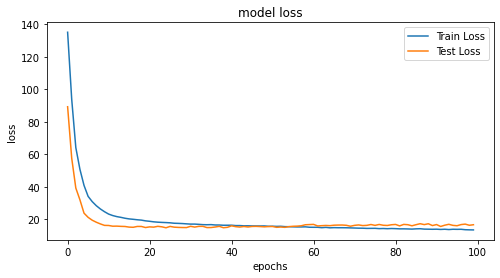

In [8]:
# make predictions
pred_train = model.predict(x_train)
pred_valid = model.predict(x_valid)
# calculate root mean squared error
print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f ' % (np.sqrt(mean_squared_error(y_train, pred_train)), mean_absolute_error(y_train, pred_train)))
print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f ' % (np.sqrt(mean_squared_error(y_valid, pred_valid)), mean_absolute_error(y_valid, pred_valid)))
model_loss(history)

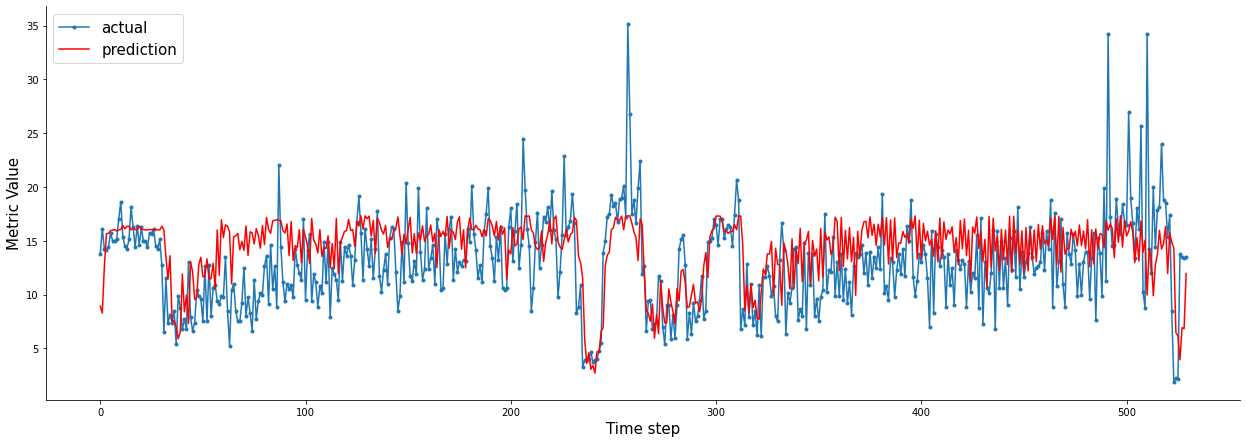

In [9]:
def prediction_plot(testY, test_predict):
    len_prediction=[x for x in range(len(testY))]
    plt.figure(figsize=(18,6))
    plt.plot(len_prediction, testY[:], marker='.', label="actual")
    plt.plot(len_prediction, test_predict[:], 'r', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Metric Value', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

prediction_plot(y_valid, pred_valid)

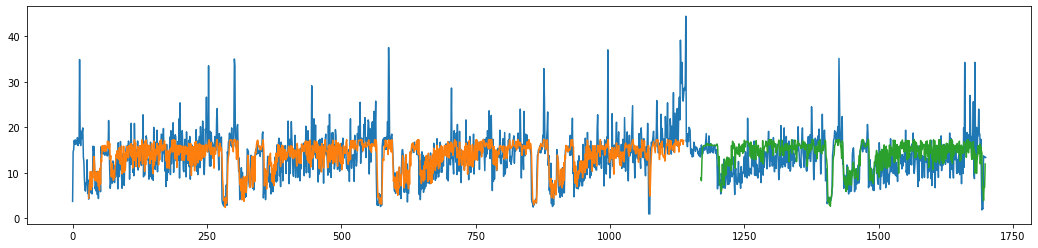

In [10]:
# shift train predictions for plotting
plt.figure(figsize=(18,4))
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(pred_train)+look_back, :] = pred_train
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(pred_train)+(look_back*2)+1:len(dataset)-1, :] = pred_valid
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()